# Data wrangling

In [3]:
import glob
import shutil
import matplotlib.pyplot as plt
import random
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub

# from utils import image_dimensions, plot_image_samples

# 1. Data download

In [4]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


# 2. Data re-structuring

Right now, the data exists in a set of numbered directories, one for each patient. In each patient directory there are two sub-directories `0` and `1` containing IDC negative and IDC positive images. We need to collect all of the IDC negative images and IDC positive images into their own directories.

In [5]:
# Get a list of patient directories
patients=glob.glob(f'{path}/*')

# Set up target directories for file copy
idc_negative_directory='../data/idc_negative/'
idc_positive_directory='../data/idc_positive/'

In [6]:
# This cell can be commented out after running at least once

Path(idc_negative_directory).mkdir(parents=True, exist_ok=True)
Path(idc_positive_directory).mkdir(parents=True, exist_ok=True)

# Loop on the patient directories and copy the '0' images to
# the idc_negative directory and the '1' images to the
# idc_positive directory
for patient in patients:

    # Copy the idc negative images from this patient
    idc_negative_images=glob.glob(f'{patient}/0/*.png')

    for image in idc_negative_images:
        shutil.copy(image, idc_negative_directory)

    # Copy the idc positive images from this patient
    idc_positive_images=glob.glob(f'{patient}/1/*.png')

    for image in idc_positive_images:
        shutil.copy(image, idc_positive_directory)


In [7]:
idc_negative_images = glob.glob(f'{idc_negative_directory}/*.png')
idc_positive_images = glob.glob(f'{idc_positive_directory}/*.png')

In [8]:
print(idc_negative_directory)

../data/idc_negative/


In [9]:
# Defining a function that plots images to inspect:

def plot_image_samples(positive_images, negative_images, rows=3, cols=2, figsize=(6, 4)):

    # Create the subplot grid
    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    # Zip positive and negative images with the subplot axes
    for positive, negative, row in zip(positive_images[:rows], negative_images[:rows], axs):
        for pic, ax in zip([positive, negative], row):
            img = load_img(pic)  # Load the image
            img_array = img_to_array(img)  # Convert to an array
            img_array /= 255.0  # Normalize the image
            ax.imshow(img_array)  # Display the image
            ax.axis('off')  # Remove axis for better visualization

    plt.tight_layout()
    plt.show()

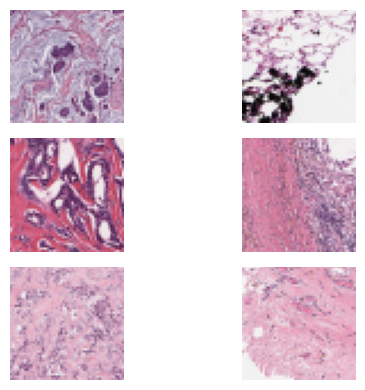

In [10]:
plot_image_samples(idc_positive_images, idc_negative_images)

## 3. EDA
Based on the Kaggle description, the images should all be 50*50 pixels each, but let's ensure that that is accurate.

### 3.1 Checking image size consistency

In [11]:
# Creating a function that plots heights and widths of a picture dataset
# And also returns the values of unique heights and widths

def image_dimensions(image_dataset, chosen_height = 50, chosen_width = 50):

    heights = []
    widths = []

    # Looping on the images to gather height and width data
    for image in image_dataset:

        # Load the image and convert it to an array
        sample_image = load_img(image)
        sample_image = img_to_array(sample_image)
        
        # Get the width and height and add to collections
        heights.append(sample_image.shape[0])
        widths.append(sample_image.shape[1])

    # Plotting results on a histogram
    plt.hist(heights, bins = 50, alpha = 0.5, label = "Image Heights")
    plt.hist(widths,  alpha = 0.5, label = "Image Widths")
    plt.xlabel('Image Dimension')
    plt.ylabel('Count')
    plt.legend(loc = 'best')
    plt.show()

    # Check if all heights are the chosen height
    unique_heights = set(heights)

    if unique_heights == {chosen_height}:
        print(f"All heights are {chosen_height}.")
    else:
        print(f"There are heights that are not equal to {chosen_height}.")
        print("Unique heights:", unique_heights)

    
    # Check if all widths are the chosen height
    unique_widths = set(widths)

    if unique_widths == {chosen_height}:
        print(f"All widths are {chosen_height}.")
    else:
        print(f"There are widths that are not equal to {chosen_height}.")
        print("Unique widths:", unique_widths)


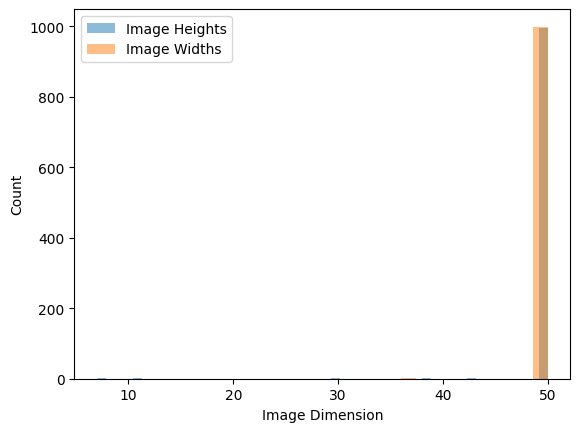

There are heights that are not equal to 50.
Unique heights: {38, 7, 43, 11, 50, 30}
There are widths that are not equal to 50.
Unique widths: {50, 36}


In [12]:
# Get a random sample of half positive and half negative images
sample_size=1000
sample=random.sample(idc_negative_images, sample_size//2)
sample+=random.sample(idc_positive_images, sample_size//2)

image_dimensions(sample)

Within the sample of 1000 images, there is one that is not 50x50, which makes me questions whether there are more. I may just delete it to avoid confusion.

In [13]:
# Looping on the sample images:
def clean_images(image_list):

    cleaned_images = []

    for sample_image in image_list:

        #Load the image and convert it to an array
        sample_image_data = load_img(sample_image)
        sample_image_data = img_to_array(sample_image_data)
        
        # Get the width and height and add to collections
        heights1=sample_image_data.shape[0]
        widths1=sample_image_data.shape[1]

        if (heights1 == 50) & (widths1 == 50):
            cleaned_images.append(sample_image)

    return cleaned_images

In [14]:
cleaned_negative_images = clean_images(idc_negative_images)
cleaned_positive_images = clean_images(idc_positive_images)


In [15]:
total_cleaned = len(cleaned_negative_images) + len(cleaned_positive_images)

print(f'There are a total of {total_cleaned} cleaned images in the dataset')

There are a total of 275222 cleaned images in the dataset


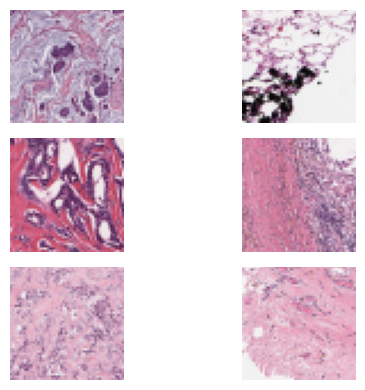

In [18]:
plot_image_samples(cleaned_positive_images, cleaned_negative_images)

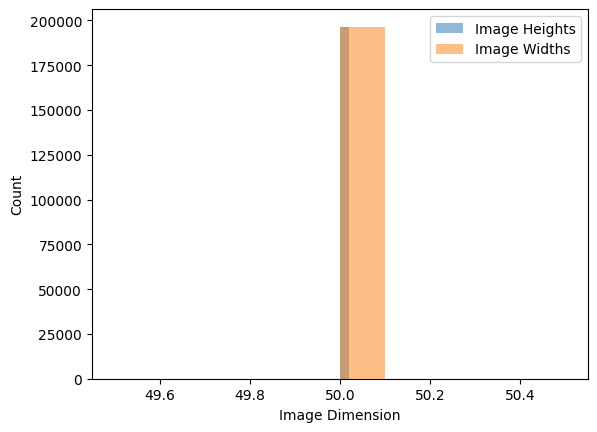

All heights are 50.
All widths are 50.


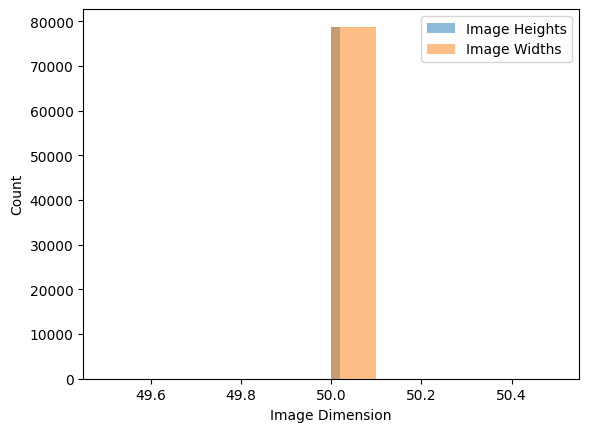

All heights are 50.
All widths are 50.


In [19]:
# Checking that the cleaned dataset only contains pictures that are 50x50 pixels
image_dimensions(cleaned_negative_images)

image_dimensions(cleaned_positive_images)

In [20]:
import pickle

In [31]:
# Creating a smaller dataset of 5000 positive and negative images to save in a pickle file

cleaned_positive_subset = random.sample(cleaned_positive_images, 5000)
cleaned_negative_subset = random.sample(cleaned_negative_images, 5000)


In [32]:
with open('positive_image_subset.pkl', 'wb') as file:
    pickle.dump(cleaned_positive_subset, file)

with open('negative_image_subset.pkl', 'wb') as file:
    pickle.dump(cleaned_negative_subset, file)

# 4. Model
### 4.1 Baseline model training

In [35]:
# From sol

# Set some global default values for how long/how much to train
SINGLE_TRAINING_RUN_EPOCHS=100
SINGLE_TRAINING_RUN_STEPS_PER_EPOCH=50
SINGLE_TRAINING_RUN_VALIDATION_STEPS=50

OPTIMIZATION_TRAINING_RUN_EPOCHS=20
OPTIMIZATION_TRAINING_RUN_STEPS_PER_EPOCH=10
OPTIMIZATION_TRAINING_RUN_VALIDATION_STEPS=10 

def single_training_run(
        training_data_path: str,
        image_width: int=50,
        aspect_ratio: float=1.0,
        batch_size: int=16,
        learning_rate: float=0.1,
        l1_penalty: float=0.0,
        l2_penalty: float=0.0,
        epochs: int=SINGLE_TRAINING_RUN_EPOCHS,
        steps_per_epoch: int=SINGLE_TRAINING_RUN_STEPS_PER_EPOCH,
        validation_steps: int=SINGLE_TRAINING_RUN_VALIDATION_STEPS
):
    '''Does one training run.'''

    # Get dictionary of all arguments being passed into function
    named_args = {**locals()}

    # Make output file name string using values of arguments
    # from function call
    results_file='../data/experiment_results/single_model_run'
    for key, value in named_args.items():
        if key != 'training_data_path':
            results_file+=f'_{value}'
    results_file+='.plk'

    # Check if we have already run this experiment, if not, run it and save the results
    if os.path.isfile(results_file) == False:

        # Calculate the image height from the width and target aspect ratio
        image_height=int(image_width / aspect_ratio)

        # Make the streaming datasets
        training_dataset, validation_dataset=make_datasets(
            training_data_path,
            image_width,
            image_height,
            batch_size
        )

        # Make the model
        model=compile_model(
            training_dataset,
            image_width,
            image_height,
            learning_rate,
            l1_penalty,
            l2_penalty
        )

        # Do the training run
        training_result=model.fit(
            training_dataset.repeat(),
            validation_data=validation_dataset.repeat(),
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=False
        )

        # Save the results
        with open(results_file, 'wb') as output_file:
            pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

    # If we have already run it, load the result so we can plot it
    elif os.path.isfile(results_file) == True:
        with open(results_file, 'rb') as output_file:
            training_result=pickle.load(output_file)

    return training_result

In [38]:
# Loading the pickle files
with open('negative_image_subset.pkl', 'rb') as file:
    negative_image_subset = pickle.load(file)

with open('positive_image_subset.pkl', 'rb') as file:
    positive_image_subset = pickle.load(file)

In [40]:
# Saving paths to the subsets

cleaned_positive_directory = Path('notebooks/positive_image_subset.pkl')
cleaned_negative_directory = Path('notebooks/negative_image_subset.pkl')

In [ ]:
# Do a single training run with default settings
training_results=single_training_run(cleaned)

# Collect the results so we can plot all of the experiments together at the end
experiment_results={'Baseline model': training_results}

# Plot the results
plot_single_training_run(training_results).show()